In [1]:
%pylab inline
from pyspark.sql.types import *
from datetime import datetime
from pyspark.sql import Row, functions as F
from pyspark.ml.feature import Tokenizer, HashingTF, Binarizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression


Populating the interactive namespace from numpy and matplotlib


In [195]:
fields = [StructField("archived", BooleanType(), True),
        StructField("author", StringType(), True),
        StructField("author_flair_css_class", StringType(), True),
        StructField("body", StringType(), True),
        StructField("controversiality", LongType(), True),
        StructField("created_utc", StringType(), True),
        StructField("day", LongType(), True),
        StructField("distinguished", StringType(), True),
        StructField("downs", LongType(), True),
        StructField("edited", StringType(), True),
        StructField("gilded", LongType(), True),
        StructField("id", StringType(), True),
        StructField("link_id", StringType(), True),
        StructField("month", LongType(), True),
        StructField("name", StringType(), True),
        StructField("parent_id", StringType(), True),
        StructField("retrieved_on", LongType(), True),
        StructField("score", LongType(), True),
        StructField("score_hidden", BooleanType(), True),
        StructField("subreddit", StringType(), True),
        StructField("subreddit_id", StringType(), True),
        StructField("ups", LongType(), True),
        StructField("year", LongType(), True)]
rawDF = sqlContext.read.json("s3n://reddit-comments/2009", StructType(fields)).persist(StorageLevel.MEMORY_AND_DISK_SER)

Sample size: 1806276


(0, 50)

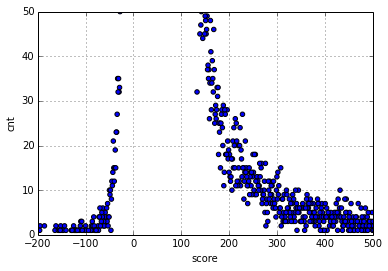

In [208]:
# Select columns that are needed for the training and testing
# Cast columns to the correct datatype for Transformers
# Only use comments that have been upvoted or downvoted
def cast_col(df, col, cast_type):
    return df.withColumn("temp_col", df[col].cast(cast_type))\
             .drop(col)\
             .withColumnRenamed("temp_col", col)

filteredDF = rawDF.select("id", "body", "score", "score_hidden", "subreddit")\
                  .filter(rawDF.body != "[deleted]")\
                  .filter(rawDF.score_hidden == False)\
                  .filter(rawDF.subreddit == "reddit.com")
castedDF = cast_col(filteredDF, "score", DoubleType())

print "Sample size: {}".format(castedDF.count())

castedDF.registerTempTable("rc")
query = sqlContext.sql("""
    SELECT score, COUNT(*) as cnt FROM rc
    GROUP BY score
    ORDER BY cnt DESC
    """)
result = query.toPandas()
result.plot(x="score", y="cnt", kind="scatter")
plt.xlim([-200,500])
plt.ylim([0, 50])



In [209]:
# Take top 5% and bottom 5% of data
extremeDF = sqlContext.sql("SELECT PERCENTILE_APPROX(score, 0.05), PERCENTILE_APPROX(score, 0.95) FROM rc")
extremeDF.take(5)


[Row(_c0=-1.4756260848003966, _c1=12.540093682744645)]

In [218]:
negativeDF = castedDF.filter(castedDF["score"] < 0)
positiveDF = castedDF.filter(castedDF["score"] > 10)

print negativeDF.count(), positiveDF.count(), castedDF.count()

111414 114957 1806276


In [220]:
# Split dataset into training and testing
mergedDF = negativeDF.unionAll(positiveDF)
splitDF = mergedDF.randomSplit([0.8, 0.2])
trainingDF = splitDF[0]
testingDF = splitDF[1]

filtered_trainingDF = trainingDF.filter((trainingDF.score != 0))
print "training size: {}".format(filtered_trainingDF.count())
print "negative sentiment: {}".format(filtered_trainingDF.filter(filtered_trainingDF.score<0).count())
print "positive sentiment: {}".format(filtered_trainingDF.filter(filtered_trainingDF.score>0).count())
print " testing size: {}".format(testingDF.count())


training size: 181063
negative sentiment: 89217
positive sentiment: 91846
 testing size: 45308


In [205]:
binarizer = Binarizer(threshold=0.0, inputCol="score", outputCol="label")
tokenizer = Tokenizer(inputCol="body", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")

lr = LogisticRegression(maxIter=10, regParam=0.01)

pipeline = Pipeline(stages=[binarizer, tokenizer, hashingTF, lr])
model = pipeline.fit(filtered_trainingDF)
prediction = model.transform(testingDF)

In [206]:
selected = prediction.select("id", "body", "prediction", "label")
positive_score_rate = binarizer.transform(castedDF).map(lambda r: r.label).mean()

def typeI_II(row):
    if row.prediction == 0 and row.label == 0:
        return Row(error_type="true_neg", cnt=1)
    elif row.prediction == 0 and row.label == 1:
        return Row(error_type="false_neg", cnt=1)
    elif row.prediction == 1 and row.label == 0:
        return Row(error_type="false_pos", cnt=1)
    else:
        return Row(error_type="true_pos", cnt=1)

typeI_II_DF = selected.map(lambda r: typeI_II(r)).toDF()
type_error_pd = typeI_II_DF.groupBy("error_type")\
                           .sum("cnt")\
                           .withColumnRenamed("SUM(cnt)", "cnt").toPandas()

type_error_pd["tot"] = type_error_pd["cnt"].sum(axis=0)
type_error_pd["perc"] = type_error_pd["cnt"]/type_error_pd["tot"]
print type_error_pd
print "percentage of comments with positive score in full set: {0:.2f}".format(positive_score_rate)
#print "                                   predictive accuracy: {}".format(accuracy)

  error_type     cnt     tot      perc
0   true_pos  294134  360147  0.816705
1  false_neg    9424  360147  0.026167
2   true_neg    2746  360147  0.007625
3  false_pos   53843  360147  0.149503

[4 rows x 4 columns]
percentage of comments with positive score in full set: 0.84


In [194]:
 rawDF.unpersist()

DataFrame[archived: boolean, author: string, author_flair_css_class: string, body: string, controversiality: bigint, created_utc: string, day: bigint, distinguished: string, downs: bigint, edited: string, gilded: bigint, id: string, link_id: string, month: bigint, name: string, parent_id: string, retrieved_on: bigint, score: bigint, score_hidden: boolean, subreddit: string, subreddit_id: string, ups: bigint, year: bigint]